# Deep Learning on Neanderthal Genes
based on the same-named article by Nikolay Oskolkov<br>
see: https://towardsdatascience.com/deep-learning-on-neanderthal-genes-ad1478cf37e7

<h3>Abstract</h3>
When Humans migrated from Africa to Eurasia (50,000 - 70,000 years ago), they met and interbreed with Neanderthal and Denisovan.<br> Question: How to find "ancient" DNA in our genome with the usage of Deep Learning

Problem to solve: Show me a stretch of your DNA and I will predict how likely it was inherited from Neanderthals

### Table of Contents:
* [Used Dataframe](#Used-Dateframe)
* [Preparing Data](#Preparing-Data)
* [Machine Learning approach](#MLA)
* [Model Usage on Human genes](#Model-on-genes)
* [Finding Intersections](#Finding-Intersections)

Introgression: Introduction of genes from one population into the genetic stock of another through repeated crossing and backcrossing

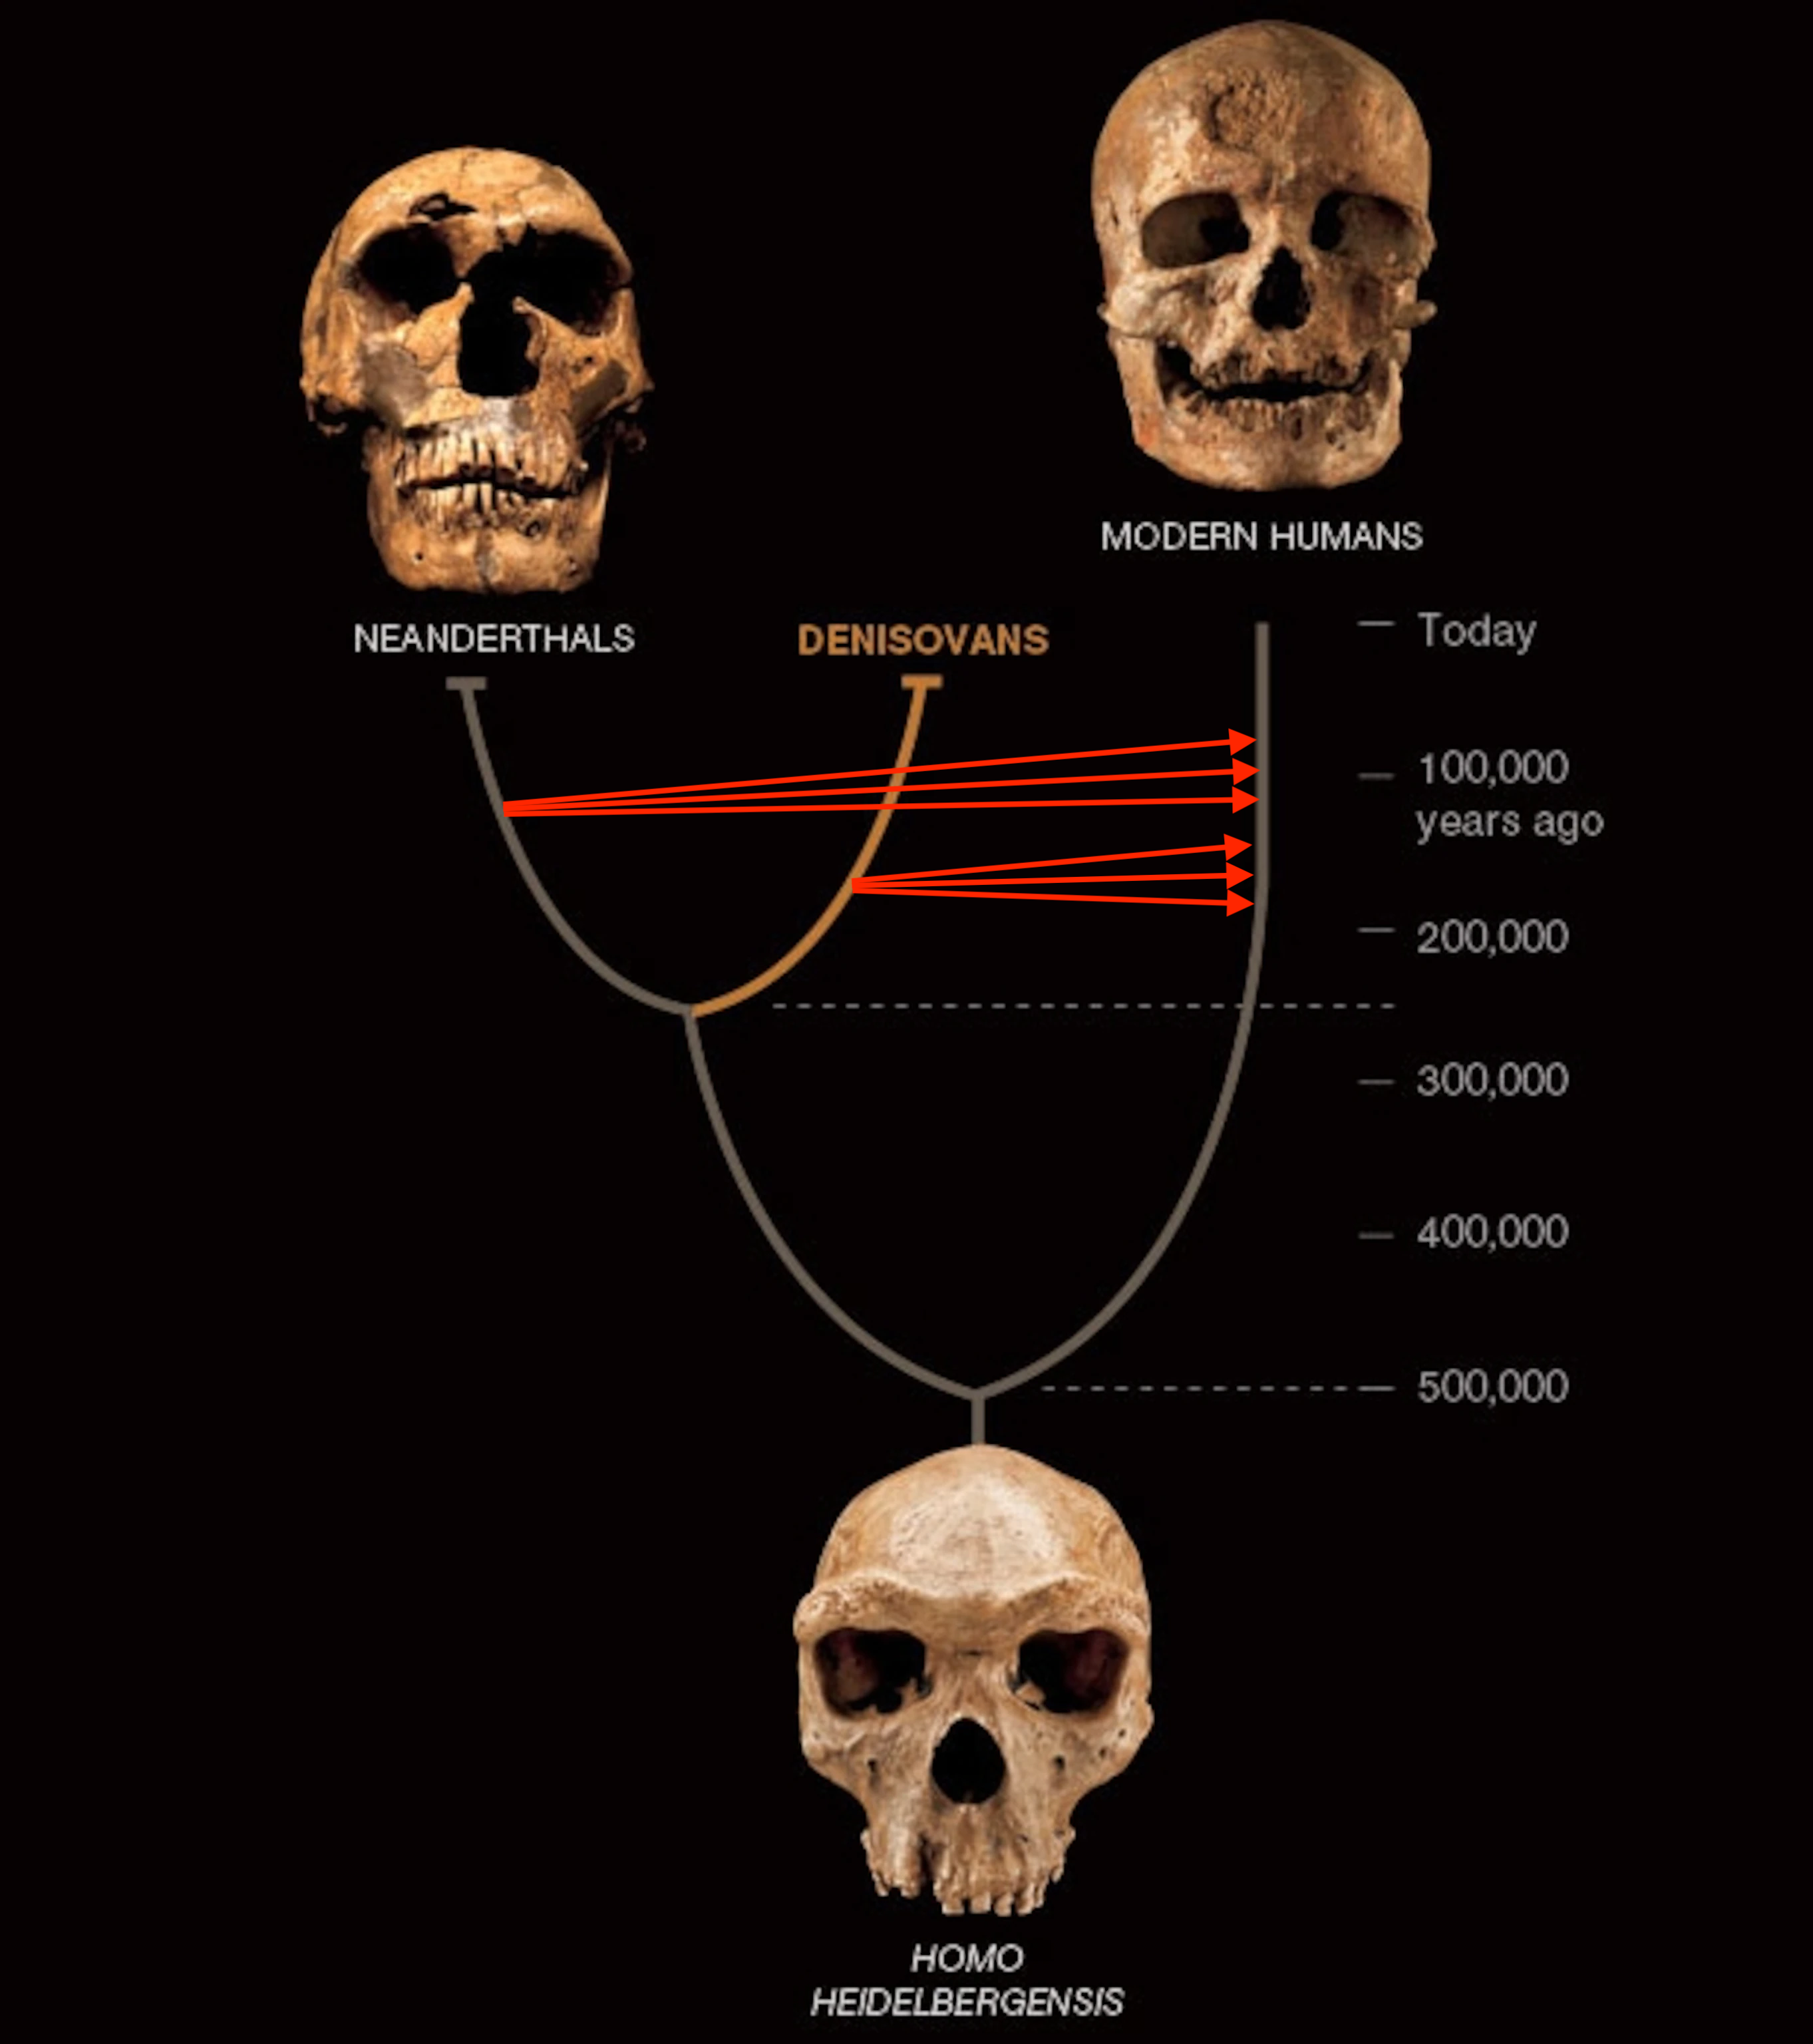

In [2]:
from IPython.display import Image
Path = '/Users/adriandoerr/Desktop/Bioinformatik/processingNGSdata/ipynbs/'
Image(Path + 'denisovan-family-tree-990x700edit.png', width=500)

source: https://www.nationalgeographic.com/culture/article/151116-denisovan-human-anthropology-ancient-dna

## Used Dataframe: <a class="anchor" id="Used-Dataframe"></a>

__Neanderthal introgressions:__ LL.callsetEUR.mr_0.99.neand_calls_by_hap.bed.merged.by_chr.bed<br>
https://drive.google.com/drive/folders/0B9Pc7_zItMCVWUp6bWtXc2xJVkk?resourcekey=0-Cj8G4QYndXQLVIGPoWKUjQ<br>
_from readme.txt:_ The basic pipeline is as follows: Filter tag SNPs to include those that match the correct
archaic, and those that belong to a 50kb window with at least two other tag SNPs. Calculate
LD (R2) among tag SNPs in the appropriate population, and cluster all tag SNPs at R2 >= 0.3 in to
one haplotype. Filter haplotypes with fewer than 5 tag SNPs. Then identify all other SNPs 
in LD (R2 >= 0.8) with any tag SNP on a haplotype.
For my analyses, I further filtered to include only haplotypes >= 10kb and with >= 10 total
SNPs, but haplotypes that don't meet this threshold are still included in these files.

chrom.ind_id.hap	hap_s_start	hap_s_end	chrom	ind_id<br>
1	2903159	2915884	1.HG00180.2	HG00180<br>
1	2903159	2915884	1.HG01512.2	HG01512<br>
1	2903159	2915884	1.HG01669.2	HG01669<br>
1	2903159	2915884	1.HG01680.2	HG01680<br>
(295,857 lines)

__Human reference genome:__ hg19 version<br>
http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/<br><br>
\>chr1<br>
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN<br>
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN<br>
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN<br>
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN<br>
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN<br>
(62,743,362 lines)

__Human protein coding genes:__ refGene_hg19<br>
https://github.com/NikolayOskolkov/DeepLearningNeanderthalIntrogression/<br><br>
chr1	stdin	transcript	11874	14409	.	+	.	gene_id "DDX11L1"; transcript_id "NR_046018";  gene_name "DDX11L1";<br>
chr1	stdin	exon	11874	12227	.	+	.	gene_id "DDX11L1"; transcript_id "NR_046018"; exon_number "1"; exon_id "NR_046018.1"; gene_name "DDX11L1";<br>
chr1	stdin	exon	12613	12721	.	+	.	gene_id "DDX11L1"; transcript_id "NR_046018"; exon_number "2"; exon_id "NR_046018.2"; gene_name "DDX11L1";<br>
chr1	stdin	exon	13221	14409	.	+	.	gene_id "DDX11L1"; transcript_id "NR_046018"; exon_number "3"; exon_id "NR_046018.3"; gene_name "DDX11L1";<br>
chr1	stdin	transcript	14362	29370	.	-	.	gene_id "WASH7P"; transcript_id "NR_024540";  gene_name "WASH7P";<br>
(1,285,553 lines)

## Preparing Data <a class="anchor" id="Preparing-Data"></a>

__Investigating Dataset__

In [5]:
%%bash
echo "Number of Haplotypes: "
cat data/LL.callsetEUR.mr_0.99.neand_calls_by_hap.bed.merged.by_chr.bed | wc -l
echo "Number of Unique Haplotypes: "
cat data/LL.callsetEUR.mr_0.99.neand_calls_by_hap.bed.merged.by_chr.bed | sort -k2,2 -k3,3 -u | wc -l
cat data/LL.callsetEUR.mr_0.99.neand_calls_by_hap.bed.merged.by_chr.bed | sort -k2,2 -k3,3 -u > Akey_intr_coords.bed
awk '{print "chr" $0}' OFS=\t Akey_intr_coords.bed > Akey_intr_coords.bed

Number of Haplotypes: 
  295857
Number of Unique Haplotypes: 
   83601


Iloc function from the pandas library is meant to retrieve values from panda dataframes. with the syntax [:,1], all values in the second columns from the dataframe will be given as output. It is also possible to perform mathematical calculations with values.

minimum:  10002  maximum:  1194940
DescribeResult(nobs=83601, minmax=(10002, 1194940), mean=92137.5803877944, variance=6139175379.516865, skewness=2.709506930216638, kurtosis=11.385582615673258)


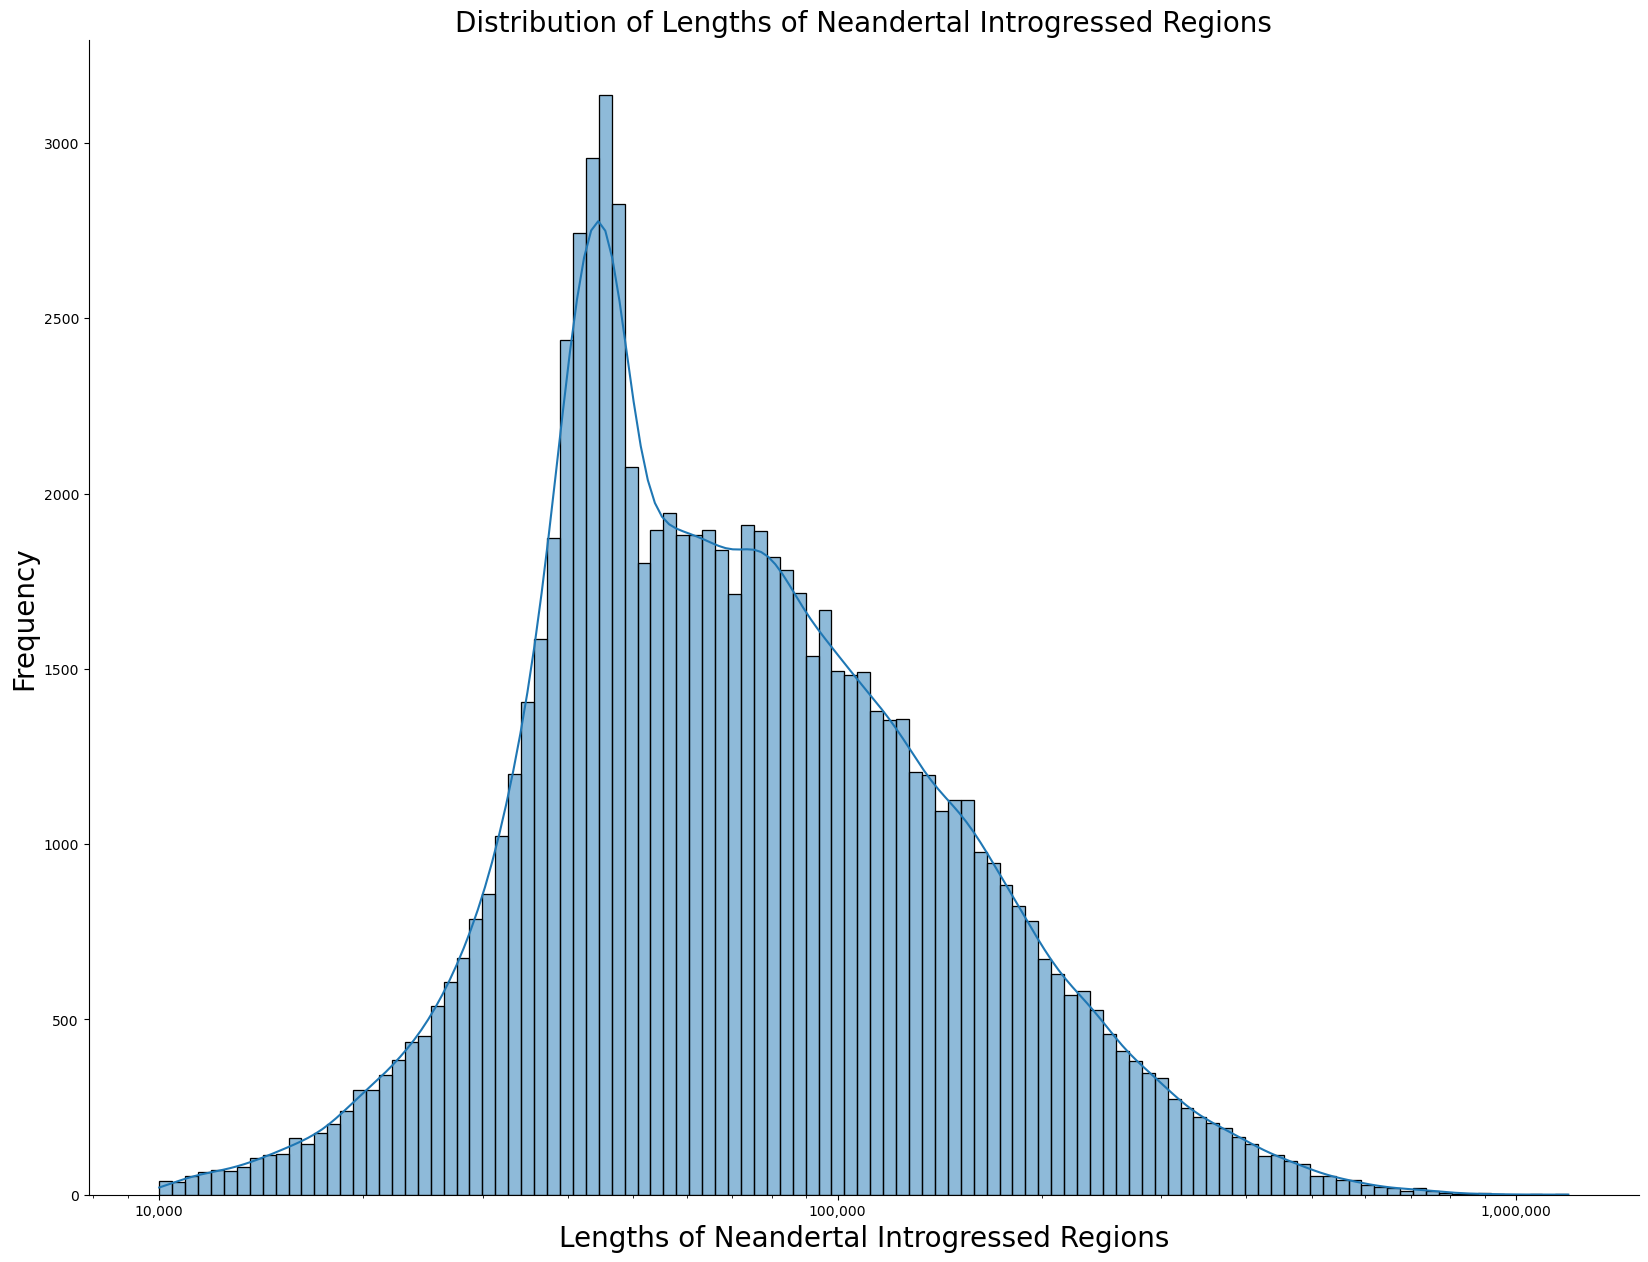

In [25]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats

intr_coords = pd.read_csv(Path + 'Akey_intr_coords.bed', header = None, sep = "\t")
intr_lengths = intr_coords.iloc[:, 2]-intr_coords.iloc[:, 1] # calculating length of every introgression

f, ax = plt.subplots(figsize=(20,15))
sns.despine(f)
sns.histplot(intr_lengths,log_scale=True,kde=True)
plt.title("Distribution of Lengths of Neandertal Introgressed Regions", fontsize = 20)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.xlabel("Lengths of Neandertal Introgressed Regions", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
print("minimum: ",intr_lengths.min()," maximum: ",intr_lengths.max())
print(stats.describe(intr_lengths))

__Assigning sequences to the Introgressions__

In [26]:
import os
import subprocess
os.chdir('/Users/adriandoerr/Desktop/Bioinformatik/processingNGSdata/ipynbs/data')
a = 0
with open('hg19_intr_regions.fa', 'a') as fp:
    for i in range(intr_coords.shape[0]):
        coord = str(str(intr_coords.iloc[i, 0]) + ':' 
                    + str(intr_coords.iloc[i, 1]) + '-' + str(intr_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.gz', str(coord)], stdout = fp)
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')

Finished 10000 Neanderthal introgressed haplotypes
Finished 20000 Neanderthal introgressed haplotypes
Finished 30000 Neanderthal introgressed haplotypes
Finished 40000 Neanderthal introgressed haplotypes
Finished 50000 Neanderthal introgressed haplotypes
Finished 60000 Neanderthal introgressed haplotypes
Finished 70000 Neanderthal introgressed haplotypes
Finished 80000 Neanderthal introgressed haplotypes


When indexing the hg19 reference genome, samtools created a fai-file which contains the lengths of the cromosomes in the second column<br>
<br>
Name    Length    Offset    Linebases    Linewidth<br>
chr1	249250621	6	50	51<br>
chr2	243199373	254235646	50	51<br>
chr3	198022430	502299013	50	51<br>
chr4	191154276	704281898	50	51<br>
chr5	180915260	899259266	50	51<br>

__Sort Introgressions per chromosome__

In [22]:
import pandas as pd
intr_coords = pd.read_csv('data/Akey_intr_coords.bed', header = None, sep = "\t")

chr_sizes = pd.read_csv("data/hg19.fa.fai", header = None, sep = "\t")
print("sorted introgression\n",intr_coords[intr_coords[0].isin([intr_coords.iloc[0,0]])])
chrom = intr_coords[intr_coords[0].isin([intr_coords.iloc[1,0]])]
print("chr location",intr_coords.iloc[0,0])

sorted introgression
           0          1          2            3        4
0      chr4  100011250  100041499  4.HG00239.2  HG00239
66     chr4  100261120  100302206  4.NA20507.2  NA20507
69     chr4  100281211  100314107  4.NA12342.2  NA12342
70     chr4  100292700  100314107  4.NA12814.2  NA12814
77     chr4  100335907  100398912  4.HG00107.1  HG00107
...     ...        ...        ...          ...      ...
83445  chr4   99790350   99863912  4.NA20518.2  NA20518
83454  chr4   99812300   99848439  4.HG01513.1  HG01513
83508  chr4   99890891   99940023  4.HG00138.1  HG00138
83509  chr4   99890891   99967801  4.HG00113.2  HG00113
83528  chr4   99906052   99940023  4.HG00323.1  HG00323

[6058 rows x 5 columns]
chr location chr4


shape: returns the shape of the underlying data of the given series object. <br>
Isin: checks if a list of values is present in a dataframe. Output is the same dataframe with either true or false as values. <br>
random.randint: function which takes two values as input and gives a random int number between them as output.

__Creating set of not-overlapping (depleted) segments__<br>
With iterating through all introgressions, a random fragment with the same length as the respective introgression is generated. It is then tested wether the segment overlaps with any introgression on the same chromosome and is saved if not. In case of overlapping, a new random segment is created and the process starts again.

In [5]:
chr_sizes = pd.read_csv("hg19.fa.fai", header = None, sep = "\t")
chr_sizes = chr_sizes.drop([2, 3, 4], axis = 1)
chr_list = []; start_list = []; end_list = []
intr_lengths = list(intr_coords.iloc[:, 2] - intr_coords.iloc[:, 1])
a = 0
for i in range(intr_coords.shape[0]):
    chr_df = intr_coords[intr_coords[0].isin([intr_coords.iloc[i,0]])] # generates a data frame for all introgressions on the same chromosome -> first df is all intr. on chr4
    overlap = True
    while overlap == True:
        reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == intr_coords.iloc[i,0]].iloc[:,1])) # basically a random number between 1 and the current chromosome length
        reg_end = reg_start + intr_lengths[i] # random fragment has the same length as real fragment
        for j in range(chr_df.shape[0]): # iteration through the number of introgressions on the current chromosome (f.e. chr5 has 4089 introgressions, therefore iteration through 4089)
            b1 = chr_df.iloc[j,1] # start coordinate of the current introgression (iterated through with j)
            b2 = chr_df.iloc[j,2] # end coordinate of the current introgression (iterated through with j)
            if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2) or \
            (b1 > reg_start and b1 < reg_end) or (b2 > reg_start and b2 < reg_end): # Check if random fragment (reg_start + reg_end) is overlapping with the current introgression
                overlap = True
                break
            else:
                overlap = False
    chr_list.append(intr_coords.iloc[i,0])
    start_list.append(reg_start)
    end_list.append(reg_end)
    a = a + 1
    if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')
depl_coords = pd.DataFrame({'0': chr_list, '1': start_list, '2': end_list})
depl_coords.to_csv("Akey_depl_coords.bed", index = False, header = False, sep = "\t")

Finished 10000 Neanderthal introgressed haplotypes
Finished 20000 Neanderthal introgressed haplotypes
Finished 30000 Neanderthal introgressed haplotypes
Finished 40000 Neanderthal introgressed haplotypes
Finished 50000 Neanderthal introgressed haplotypes
Finished 60000 Neanderthal introgressed haplotypes
Finished 70000 Neanderthal introgressed haplotypes
Finished 80000 Neanderthal introgressed haplotypes


Erste Iteration: durch alle 83601 vorhande Introgressions<br>
&emsp;Bildung eines Dataframes welches alle Introgressions auf einem Chromosom mit Koordinaten beinhaltet (bsp. 4089 auf chr5)<br>
&emsp;Zweite Iteration: so lange wie "Overlap == True" ist<br>
&emsp;&emsp;Bildung eines Random Fragments basierend auf der momentanen Chromosomgröße (chr_sizes) mit der gleichen Länge wie die Länge der momentanen Introgression (i)<br>
&emsp;&emsp;Dritte Iteration: durch alle Introgressions auf dem gleichen Chromosom (bsp. 4089 auf chr5 -> 4089 mal)<br>
&emsp;&emsp;&emsp;Prüfung ob eine Überlappung zwischen dem random Fragment und allen anderen Introgressions auf dem gleichen Chromosom vorhanden ist<br>
&emsp;&emsp;&emsp;Falls ja: Rückkehr zur zweiten Iteration und Neuberechnung eines Random Fragments<br>
&emsp;&emsp;&emsp;alls nein für alle Introgressions auf dem Chromosom: Ende der inneren Schleife und Speicherung des Random Fragments mit dem Jeweiligen Chromosoms<br>
Umwandlung der gesammelten Informationen in einen Dataframe und Speicherung in einer .csv Datei<br>

__Plotting Introgressions and Depletions number per chromosome__

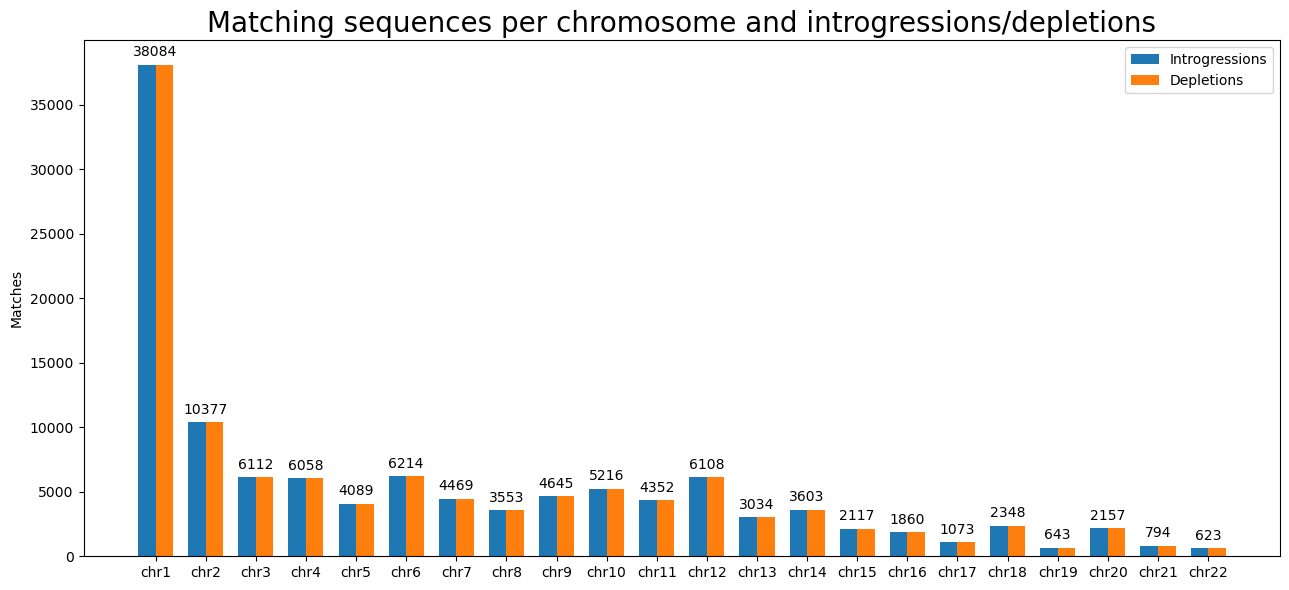

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted

intrcount=[]
deplcount=[]
intr = pd.read_csv("data/Akey_intr_coords.bed", header = None, sep = "\t").iloc[:,0].astype(str)
depl = pd.read_csv("data/Akey_depl_coords.bed", header = None, sep = "\t").iloc[:,0].astype(str)

chrlist = set(intr_coords.iloc[:,0].tolist())

for i in natsorted(chrlist):
    intrcount.append(intr.str.count(str(i)).sum())
    deplcount.append(depl.str.count(str(i)).sum())

x = np.arange(len(natsorted(chrlist)))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(13,6))
rects1 = ax.bar(x - width/2, intrcount, width, label='Introgressions')
rects2 = ax.bar(x + width/2, deplcount, width, label='Depletions')
rectsm = ax.bar(x , intrcount, width = 0)

ax.set_ylabel('Matches')
ax.set_title('Matching sequences per chromosome and introgressions/depletions', fontsize = 20)
ax.set_xticks(x, natsorted(chrlist))
ax.legend()
ax.bar_label(rectsm, padding=4)

fig.tight_layout()

plt.show()

__Assigning sequences to the Depletions__

In [2]:
depl_coords = pd.read_csv("data/Akey_depl_coords.bed", header = None, sep = "\t")
depl_lengths = depl_coords.iloc[:, 2] - depl_coords.iloc[:, 1]

import os
import subprocess
a = 0
os.chdir('/Users/adriandoerr/Desktop/Bioinformatik/processingNGSdata/ipynbs')
with open('hg19_depl_regions.fa', 'a') as fp:
    for i in range(depl_coords.shape[0]):
        coord = str(str(depl_coords.iloc[i, 0]) + ':' 
                    + str(depl_coords.iloc[i, 1]) + '-' + str(depl_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.gz', str(coord)], stdout = fp)
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')

[faidx] Truncated sequence: chr10:135473477-135544479


Processing: chr12 : 57710729 - 57742772


[faidx] Truncated sequence: chr6:170804369-171168695


Processing: chr12 : 56662472 - 56899484


[faidx] Truncated sequence: chr8:146353316-146674815
[faidx] Truncated sequence: chr8:146290510-146632964


Processing: chr6 : 150133739 - 150180549


[faidx] Truncated sequence: chr4:191077556-191252462


Processing: chr12 : 55649885 - 55743418


[faidx] Truncated sequence: chr10:135387194-135813426


Processing: chr2 : 234399052 - 234435896


[faidx] Truncated sequence: chr9:141188736-141318379
[faidx] Truncated sequence: chr9:141163357-141313933


Processing: chr9 : 68233318 - 68277898


[faidx] Truncated sequence: chr4:191117857-191159110


Processing: chr2 : 17323637 - 17407787


[faidx] Truncated sequence: chr11:134875941-135034400


Processing: chr6 : 146769280 - 146817770
Processing: chr3 : 608673 - 693196


[faidx] Truncated sequence: chr4:191003551-191192210


Processing: chr5 : 25720991 - 25760886
Finished 10000 Neanderthal introgressed haplotypes


[faidx] Truncated sequence: chr4:191047408-191466491


Processing: chr5 : 170604448 - 170665309


[faidx] Truncated sequence: chr5:180828582-180951449
[faidx] Truncated sequence: chr10:135508743-135551676


Processing: chr2 : 83276407 - 83577129
Processing: chr7 : 115342668 - 115425563
Processing: chr6 : 86086959 - 86227382


[faidx] Truncated sequence: chr3:197831234-198356704
[faidx] Truncated sequence: chr8:146232879-146395143
[faidx] Truncated sequence: chr8:146082661-146389620
[faidx] Truncated sequence: chr3:197991831-198108400
[faidx] Truncated sequence: chr8:146217827-146597578
[faidx] Truncated sequence: chr10:135501513-135612913


Processing: chr3 : 103489899 - 103531983


[faidx] Truncated sequence: chr16:90312073-90367389
[faidx] Truncated sequence: chr6:170972285-171190747
[faidx] Truncated sequence: chr4:191121165-191204620


Processing: chr8 : 62313313 - 62469634
Processing: chr8 : 30525910 - 30595609


[faidx] Truncated sequence: chr2:243082665-243392306
[faidx] Truncated sequence: chr2:242998607-243261127
[faidx] Truncated sequence: chr3:197963343-198061462


Processing: chr3 : 111067258 - 111137764


[faidx] Truncated sequence: chr3:197776126-198149038


Processing: chr5 : 151296333 - 151328067
Processing: chr1 : 182958442 - 182992774
Finished 20000 Neanderthal introgressed haplotypes


[faidx] Truncated sequence: chr3:197942436-198053782
[faidx] Truncated sequence: chr5:180797590-181066118


Processing: chr6 : 30331311 - 30493414
Processing: chr4 : 143009646 - 143034663
Processing: chr1 : 158108514 - 158144286


[faidx] Truncated sequence: chr4:190960310-191690922
[faidx] Truncated sequence: chr4:190871380-191453936
[faidx] Truncated sequence: chr4:190986026-191157636


Processing: chr4 : 4713660 - 4825871


[faidx] Truncated sequence: chr20:62905835-63027993


Processing: chr20 : 30397530 - 30492764
Processing: chr4 : 89412942 - 89464799
Processing: chr17 : 5335625 - 5381340
Processing: chr19 : 38651136 - 38696412
Processing: chr20 : 10804571 - 10850155


[faidx] Truncated sequence: chr2:243119601-243290662


Processing: chr3 : 59019154 - 59069665
Finished 30000 Neanderthal introgressed haplotypes
Processing: chr3 : 77571481 - 77614693


[faidx] Truncated sequence: chr12:133850839-133919371


Processing: chr12 : 1315378 - 1340209


[faidx] Truncated sequence: chr3:197995348-198105908
[faidx] Truncated sequence: chr8:146296272-146368338


Processing: chr13 : 92902591 - 93019569


[faidx] Truncated sequence: chr1:248946375-249310755


Processing: chr1 : 63055083 - 63124040
Processing: chr1 : 195598011 - 195691009


[faidx] Truncated sequence: chr1:249116013-249257222
[faidx] Truncated sequence: chr2:243037682-243219356


Processing: chr1 : 1521114 - 1560099


[faidx] Truncated sequence: chr12:133801136-133901247


Processing: chr1 : 8554832 - 8902496
Processing: chr13 : 70556517 - 70583059
Processing: chr11 : 60861917 - 60886111
Processing: chr3 : 102855521 - 102898138
Finished 40000 Neanderthal introgressed haplotypes


[faidx] Truncated sequence: chr12:133838381-133992509


Processing: chr12 : 52857785 - 52938659


[faidx] Truncated sequence: chr10:135519023-135629456
[faidx] Truncated sequence: chr12:133809130-133884052
[faidx] Truncated sequence: chr7:159053209-159335347
[faidx] Truncated sequence: chr12:133773715-133890840


Processing: chr13 : 30136587 - 30226343


[faidx] Truncated sequence: chr4:191069428-191166710
[faidx] Truncated sequence: chr4:190984020-191235002


Processing: chr3 : 161260644 - 161306910
Processing: chr8 : 43777098 - 43821301


[faidx] Truncated sequence: chr11:134989958-135096434
[faidx] Truncated sequence: chr8:146276548-146387820


Processing: chr12 : 55556843 - 55661758


[faidx] Truncated sequence: chr10:135512846-135563076


Processing: chr12 : 43298361 - 43324628


[faidx] Truncated sequence: chr17:81046844-81249184


Processing: chr5 : 152401138 - 152441234


[faidx] Truncated sequence: chr13:115163183-115266962
[faidx] Truncated sequence: chr14:107281264-107528263
[faidx] Truncated sequence: chr21:48118755-48145252


Processing: chr21 : 5033216 - 5096463


[faidx] Truncated sequence: chr4:191133314-191181499


Processing: chr14 : 5511064 - 5743820


[faidx] Truncated sequence: chr4:191126517-191172016


Processing: chr20 : 336682 - 387130
Finished 50000 Neanderthal introgressed haplotypes


[faidx] Truncated sequence: chr14:107346268-107382774
[faidx] Truncated sequence: chr14:107230220-107394419
[faidx] Truncated sequence: chr7:159134634-159246952


Processing: chr12 : 119994880 - 120392592


[faidx] Truncated sequence: chr7:159063843-159143793
[faidx] Truncated sequence: chr7:159109323-159212348


Processing: chr21 : 10558126 - 10575415
Processing: chr14 : 8070930 - 8240514


[faidx] Truncated sequence: chr18:77993716-78080158


Processing: chr3 : 518218 - 618467


[faidx] Truncated sequence: chr11:134914814-135017774


Processing: chr13 : 10689951 - 10777087


[faidx] Truncated sequence: chr22:51294197-51331402
[faidx] Truncated sequence: chr22:51252162-51308457
[faidx] Truncated sequence: chr7:159111174-159244402
[faidx] Truncated sequence: chr14:107333845-107362444


Processing: chr16 : 2702841 - 2813801


[faidx] Truncated sequence: chr18:77807193-78140722


Processing: chr15 : 83034143 - 83086204
Processing: chr18 : 35631101 - 35676466
Processing: chr6 : 105113492 - 105456418
Processing: chr20 : 21701706 - 21766942
Finished 60000 Neanderthal introgressed haplotypes


[faidx] Truncated sequence: chr20:62992522-63069769
[faidx] Truncated sequence: chr18:77572206-78136193
[faidx] Truncated sequence: chr18:77748848-78359096
[faidx] Truncated sequence: chr14:107083267-107442620
[faidx] Truncated sequence: chr14:107288607-107649347


Processing: chr18 : 46344152 - 46738151


[faidx] Truncated sequence: chr4:191152637-191187977
[faidx] Truncated sequence: chr5:180768706-181048981


Processing: chr10 : 81262260 - 81401510


[faidx] Truncated sequence: chr12:133848350-133975291
[faidx] Truncated sequence: chr12:133771290-134062158


Processing: chr10 : 24368079 - 24457445
Processing: chr6 : 6398336 - 6527708


[faidx] Truncated sequence: chr8:146176466-146595238
[faidx] Truncated sequence: chr6:170759094-171238202
[faidx] Truncated sequence: chr18:78064472-78188080


Processing: chr2 : 87829047 - 87875309


[faidx] Truncated sequence: chr6:171114273-171235172
[faidx] Truncated sequence: chr3:197956375-198045910
[faidx] Truncated sequence: chr14:107295007-107388581


Processing: chr7 : 122730637 - 122767395
Processing: chr18 : 46487691 - 46600894


[faidx] Truncated sequence: chr8:146272087-146414583


Processing: chr18 : 27022767 - 27066738


[faidx] Truncated sequence: chr6:170834370-171248747
[faidx] Truncated sequence: chr6:170967382-171377022


Processing: chr3 : 97087166 - 97115243


[faidx] Truncated sequence: chr14:107219925-107371971
[faidx] Truncated sequence: chr14:107307353-107419543
[faidx] Truncated sequence: chr18:78059775-78082929


Processing: chr14 : 6533283 - 6609069
Finished 70000 Neanderthal introgressed haplotypes


[faidx] Truncated sequence: chr18:78052223-78092456
[faidx] Truncated sequence: chr12:133836211-133887536


Processing: chr16 : 45123299 - 45216535


[faidx] Truncated sequence: chr14:107336056-107444094
[faidx] Truncated sequence: chr18:78023815-78187747
[faidx] Truncated sequence: chr16:90278989-90380917
[faidx] Truncated sequence: chr18:78061659-78100831


Processing: chr6 : 82401868 - 82516586


[faidx] Truncated sequence: chr6:170985269-171290429
[faidx] Truncated sequence: chr16:90318166-90414053


Processing: chr6 : 154549486 - 154594248
Processing: chr1 : 111001536 - 111254196


[faidx] Truncated sequence: chr14:107341000-107411736


Processing: chr4 : 3864482 - 3906007


[faidx] Truncated sequence: chr5:180830971-180999516


Processing: chr9 : 130901899 - 130977391
Processing: chr2 : 214201509 - 214254584


[faidx] Truncated sequence: chr15:102474114-102634444
[faidx] Truncated sequence: chr12:133807368-134201290


Processing: chr8 : 81136984 - 81184137
Processing: chr10 : 41065351 - 41132682
Processing: chr12 : 61916334 - 61964063
Finished 80000 Neanderthal introgressed haplotypes


[faidx] Truncated sequence: chr18:78058800-78195359
[faidx] Truncated sequence: chr20:62985990-63026985
[faidx] Truncated sequence: chr10:135509347-135761903


Processing: chr10 : 106336717 - 106374440


[faidx] Truncated sequence: chr6:171097388-171142567
[faidx] Truncated sequence: chr10:135381218-135602183


Processing: chr9 : 58052033 - 58147074


[faidx] Truncated sequence: chr9:141151703-141235428


Processing: chr15 : 94863521 - 94908996


__Cleaning segments__

In [3]:
from Bio import SeqIO
intr_file = 'hg19_intr_regions.fa'
depl_file = 'hg19_depl_regions.fa'
a = 0; i = 0
with open('hg19_intr_clean.fa', 'a') as intr_out,open('hg19_depl_clean.fa', 'a') as depl_out:
    for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
        upper_intr = intr.seq.upper()
        upper_depl = depl.seq.upper()
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' entries')
        if 'N' not in str(upper_intr) and 'N' not in str(upper_depl):
            intr.seq = upper_intr
            SeqIO.write(intr, intr_out, 'fasta')
            depl.seq = upper_depl
            SeqIO.write(depl, depl_out, 'fasta')
            i = i + 1
        else:
            continue
print('We have processed ' + str(a) + ' entries and written ' + str(i) 
      + ' entries to two fasta-files')

Finished 10000 entries
Finished 20000 entries
Finished 30000 entries
Finished 40000 entries
Finished 50000 entries
Finished 60000 entries
Finished 70000 entries
Finished 80000 entries
We have processed 83601 entries and written 73694 entries to two fasta-files


In [31]:
%%bash
echo "hg19_intr_regions lines" | tr '\n' ':'; cat data/hg19_intr_regions.fa | grep ">" | wc -l
echo "hg19_depl_regions lines" | tr '\n' ':'; cat data/hg19_depl_regions.fa | grep ">" | wc -l
echo ""
echo "cat hg19_intr_clean lines" | tr '\n' ':'; cat data/hg19_intr_clean.fa | grep ">" | wc -l
echo "cat hg19_depl_clean lines" | tr '\n' ':'; cat data/hg19_depl_clean.fa | grep ">" | wc -l

hg19_intr_regions lines:   83601
hg19_depl_regions lines:   83601

cat hg19_intr_clean lines:   73694
cat hg19_depl_clean lines:   73694


__Creating Kmers from sequence-sets__

In [1]:
from Bio import SeqIO
from Bio.Seq import Seq
intr_file = 'data/hg19_intr_clean.fa'; depl_file = 'data/hg19_depl_clean.fa'; e = 0
intr_seqs = []; depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    cutoff = 10000
    my_intr_seq = str(intr.seq)[0:cutoff]
    my_depl_seq = str(depl.seq)[0:cutoff]
    intr_seqs.append(my_intr_seq)
    depl_seqs.append(my_depl_seq)
    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')
print('Finished with ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 5
intr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]
depl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]

Finished 20000 entries
Finished 40000 entries
Finished 60000 entries
Finished with 73694 entries


In [35]:
import numpy as np
print(np.shape(intr_texts))
print(intr_texts[0].count(' '))

(73694,)
9995


In [1]:
import pickle

PPath = '/Users/adriandoerr/Desktop/Bioinformatik/processingNGSdata/ipynbs/pickle_checkpoints/'

"""with open('intr_texts.pkl','wb') as ipkl, open('depl_texts.pkl','wb') as dpkl:
    pickle.dump(intr_texts,ipkl)
    pickle.dump(depl_texts,dpkl)"""

with open(PPath + 'intr_texts.pkl', 'rb') as ipkl, open(PPath + 'depl_texts.pkl','rb') as dpkl:
    print("starting intr_texts")
    intr_texts = pickle.load(ipkl)
    print("starting depl_texts")
    depl_texts = pickle.load(dpkl)

starting intr_texts
starting depl_texts


zip function: returns an object with tuples of every first, second, etc. item of the input tuple objects<br>
&emsp;e.g.: input1=(1,2,3);input2=(4,5,6); zip(input1,input2) -> ((1,4),(2,5),(3,6))

In [37]:
from Bio import SeqIO
from Bio.Seq import Seq
intr_file = 'data/hg19_intr_clean.fa'; depl_file = 'data/hg19_depl_clean.fa'

a = 0
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    cutoff = 10
    
    print(a,"intr",str(intr.seq)[0:cutoff])
    print(a,"depl",str(depl.seq)[0:cutoff])
    a = a + 1
    if a % 5 == 0:
        break
print("\n",len(intr_seqs))
print(len(intr_seqs[0]))
print("\n",len(intr_texts))
print(intr_texts[0].count(' '))
print(depl_texts[0].count(' '))

0 intr ATAGGGACTC
0 depl AATTCTCAGT
1 intr GTGTTGTATA
1 depl AGCCTAATGG
2 intr TTTACCTGTT
2 depl CGGTAATCCC
3 intr GCTAATATTT
3 depl ATACTCATTC
4 intr CAGGAAGAAA
4 depl GCATTAATCA

 73694
10000

 73694
9995
9995


done


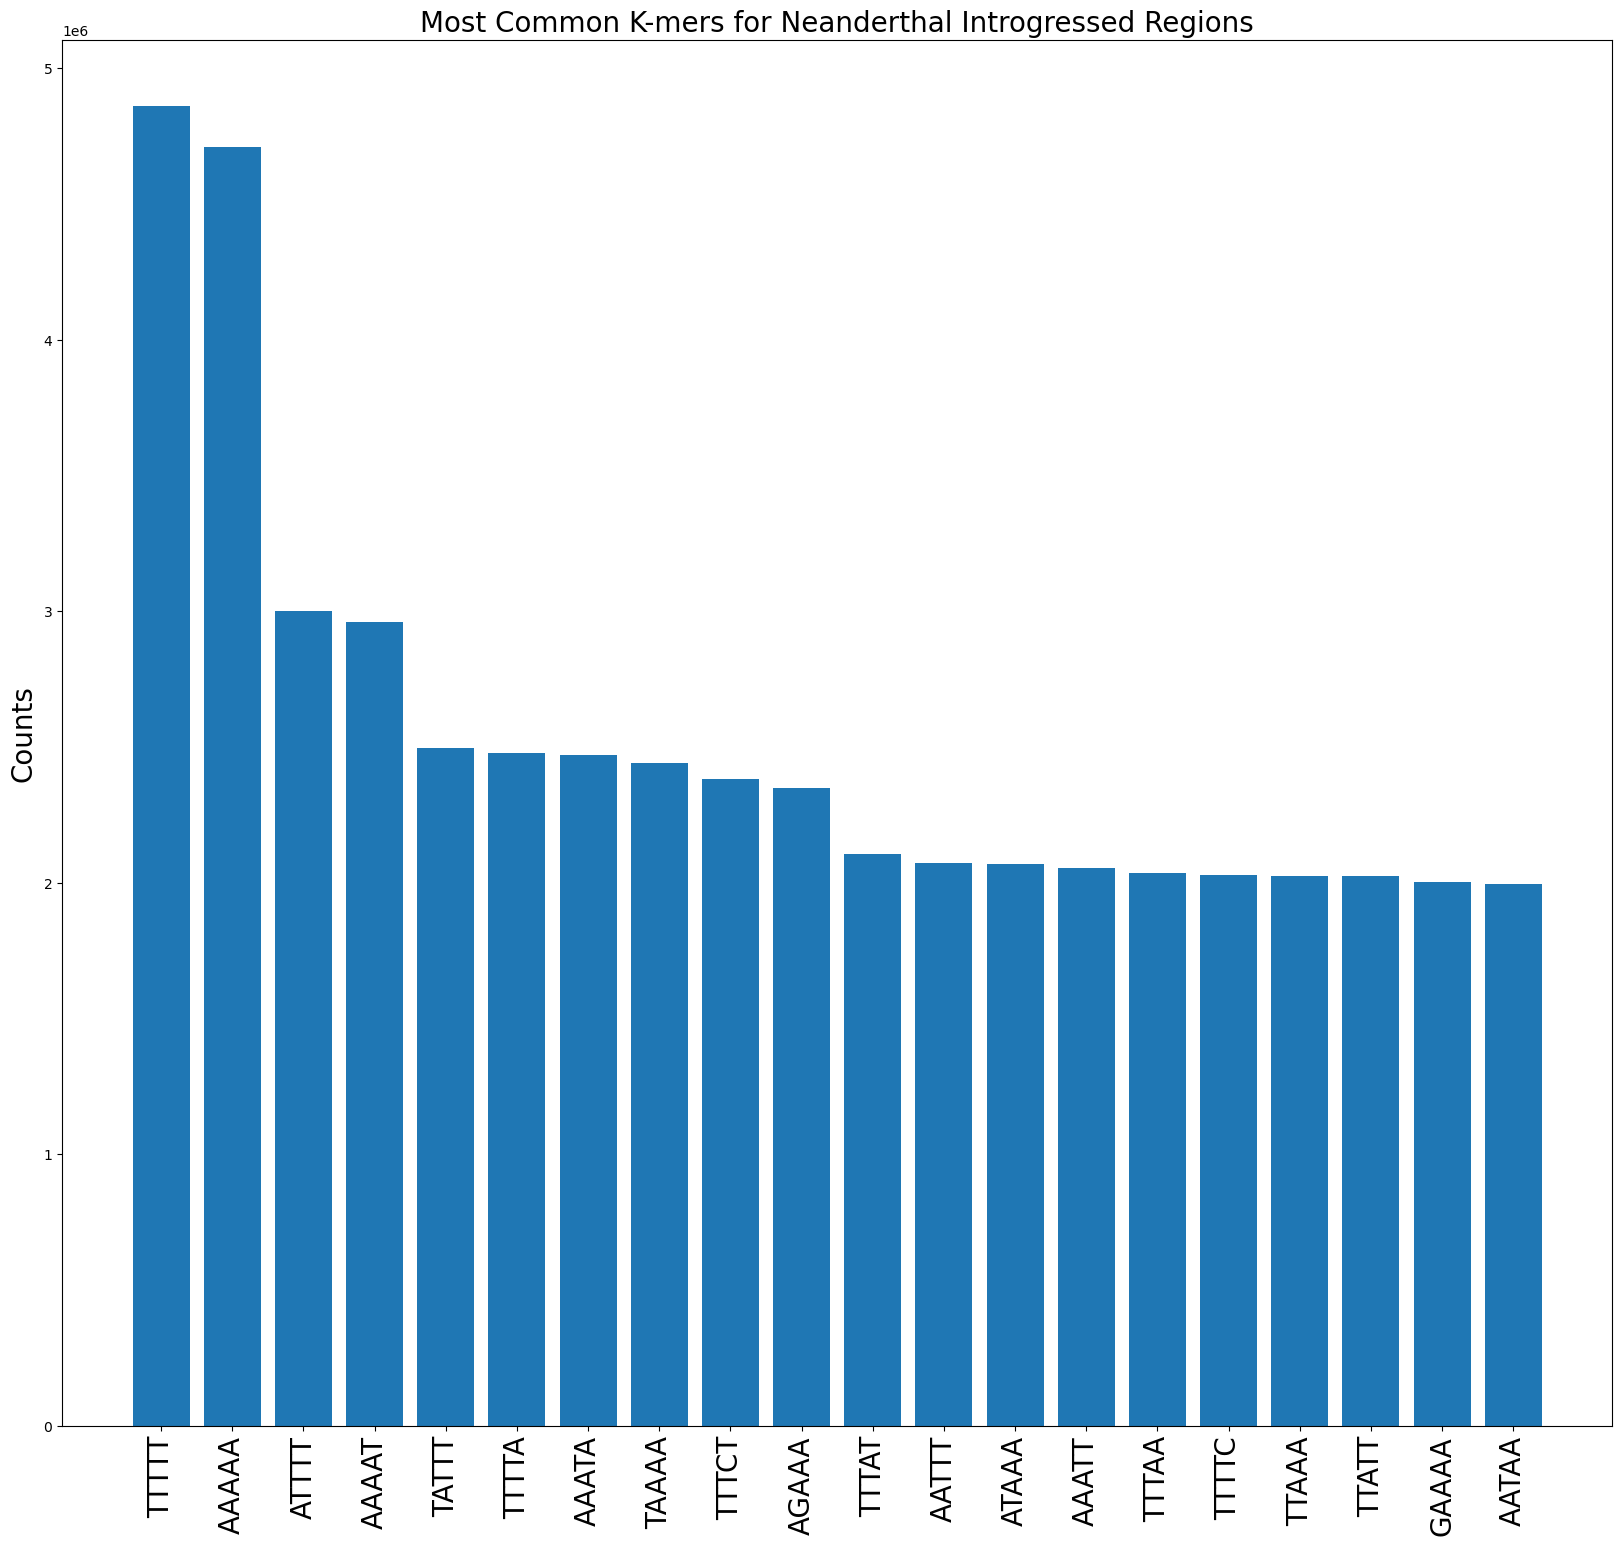

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20,18))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

plt.subplot(1, 1, 1)
intr_sentences = [item.split(' ') for item in intr_texts]
print('done')
D = dict(Counter([item for sublist in intr_sentences for item in sublist]).most_common(20))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.title('Most Common K-mers for Neanderthal Introgressed Regions', fontsize = 20)
plt.ylabel("Counts", fontsize = 20); plt.xticks(rotation = 90)
plt.xticks(range(len(D)), list(D.keys()), fontsize = 20)

plt.show()

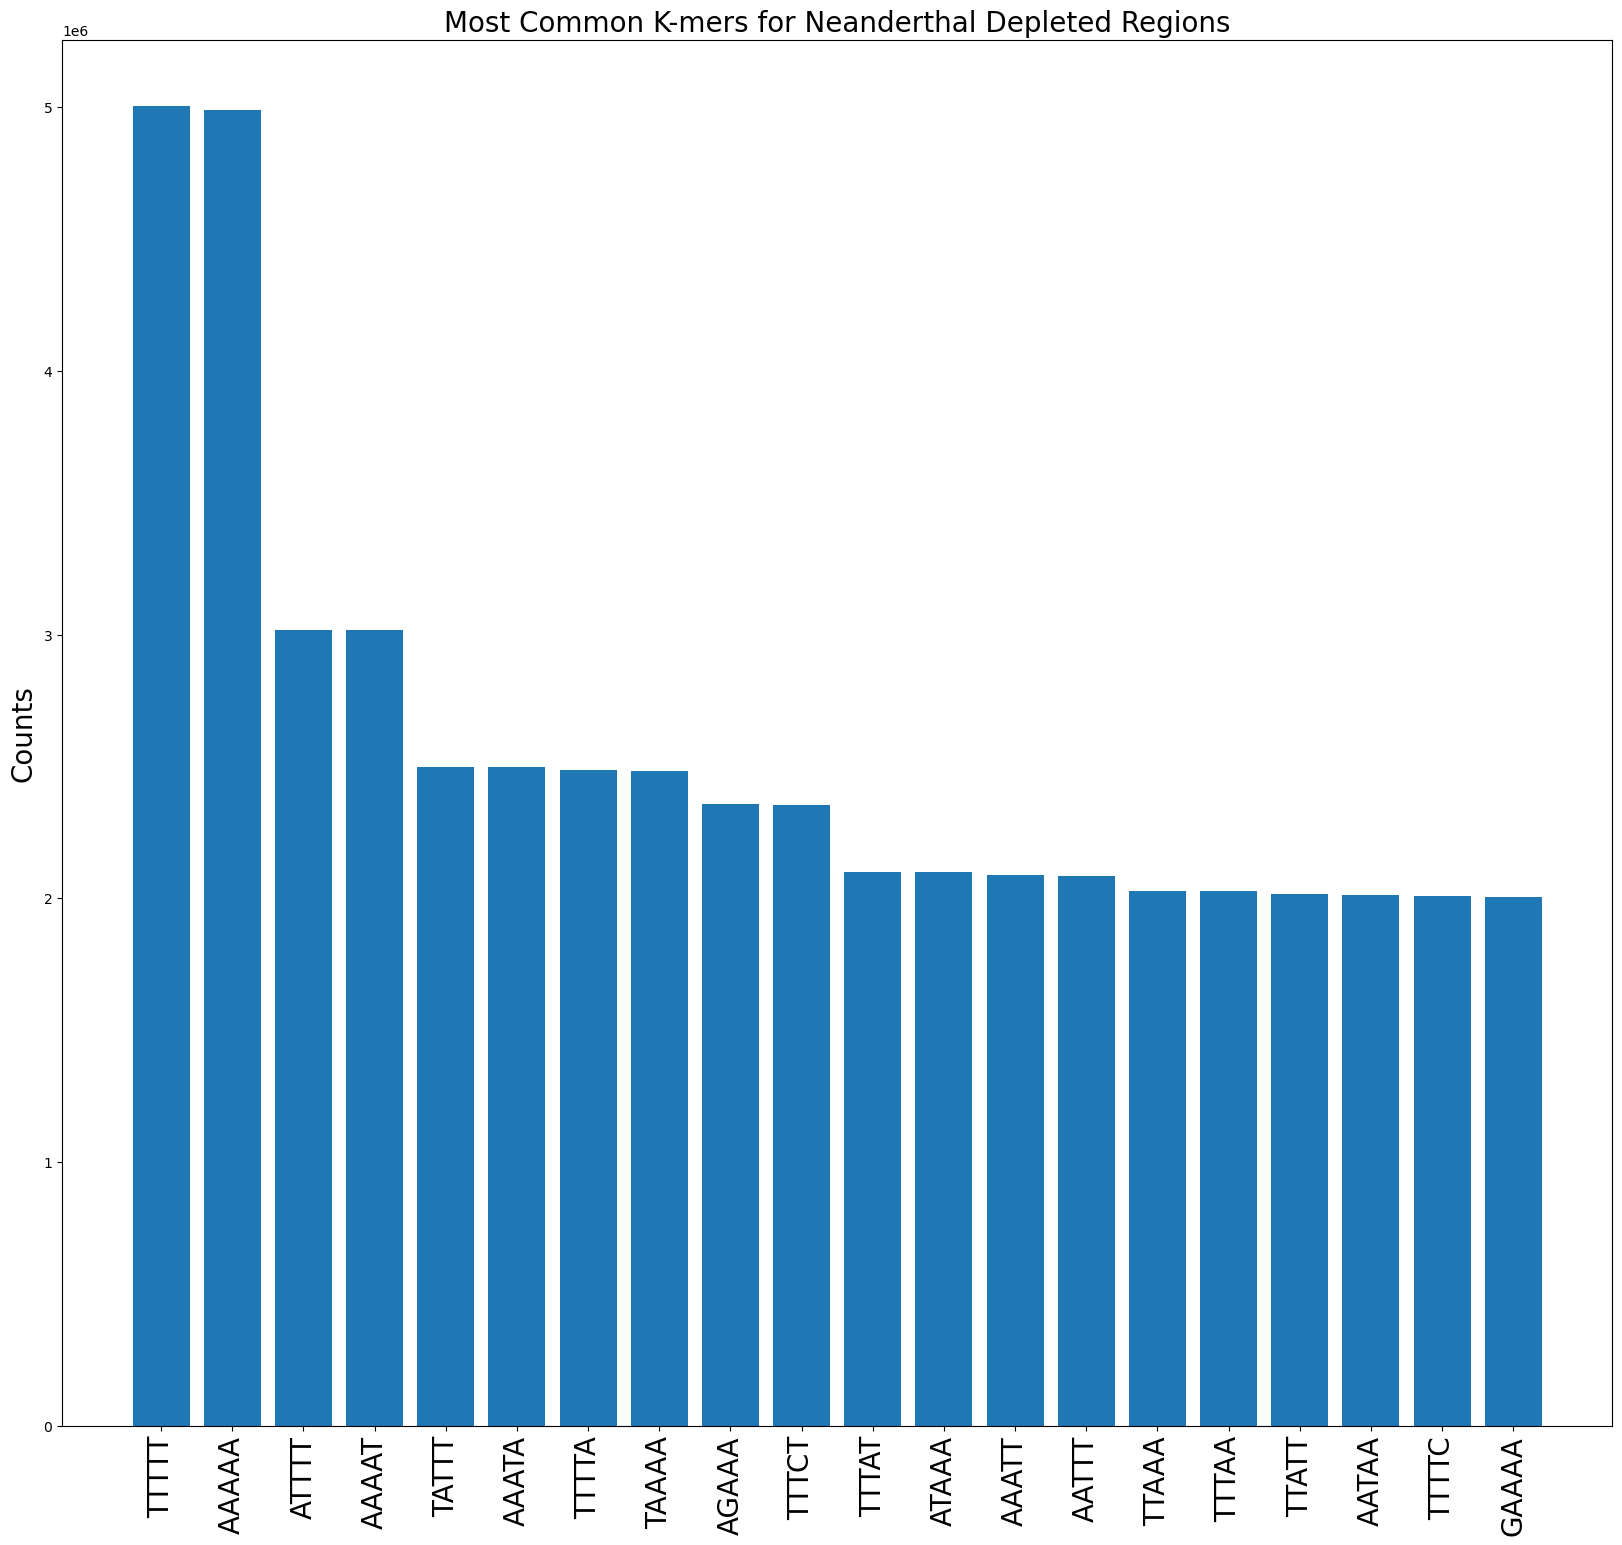

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (20,18))
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

plt.subplot(1, 1, 1)
depl_sentences = [item.split(' ') for item in depl_texts]
D = dict(Counter([item for sublist in depl_sentences for item in sublist]).most_common(20))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.title('Most Common K-mers for Neanderthal Depleted Regions', fontsize = 20)
plt.ylabel("Counts", fontsize = 20); plt.xticks(rotation = 90)
plt.xticks(range(len(D)), list(D.keys()), fontsize = 20)

plt.show()

## Machine Learning approach <a class="anchor" id="MLA"></a>

__Preparing data for ML__

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

merge_texts = intr_texts + depl_texts # appends depl kmer list to intr kmer list
labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts))) # 1 for every introgression, 0 for every depletion
cv = CountVectorizer()
X = cv.fit_transform(merge_texts) # words are counted and scaled with mean and standard deviation
X = np.int32(X.toarray())
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20, random_state = 42)

merging list -> appending list b to list a: 2 x 73694 entries before and 1 x 147388 after merging<br>
np.ones -> takes int as argument and returns array of given shape and type filled with ones<br>
Count vectorizer transform -> Counts words of a given text and vectorizes them<br>
&emsp;since X.shape -> (147388, 1024), the numpy-array X contains one inner list for each sequence cut in kmers with 1024 entries each counting the occurence of 1 kmer.<br>
&emsp;since X_train.shape -> (117910, 1024) and (147388 * 0.8 = 117910.4), exactly 80 % of the data was transferred in the train set<br>
train_test_split brings each position of both lists together, shuffles them in a reproducible manner and splits them in train and test sets<br>
<br>
Therefore: X_train[0] -> [54 31 23 ... 27 19 36](1024 entries), y_train[0] -> 0.0

In [23]:
print(X_train.shape[1])

1024


__Neural Network__

In [ ]:
from keras.models import Sequential
from keras.regularizers import l2, l1
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam, Adadelta
from keras.layers import Dense, Flatten, Dropout

X_train = np.array(X_train)
y_train = np.array(y_train)

model = Sequential()
model.add(Dense(3000, input_shape = (X.shape[1], ), # 1. layer: number of neurons and the shape of input,
                activation = 'sigmoid',             # activation function,
                kernel_regularizer = l1(0.00001)))  # learning rate
model.add(Dense(1, activation = 'sigmoid'))         # 2. layer
sgd = SGD(lr = 0.0001, momentum = 0.9, nesterov = False) # defining optimizer
model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['binary_accuracy']) # sum of negative logarithmic prediction accuracy
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_binary_accuracy', verbose=2, save_best_only = True, mode = 'max')
history = model.fit(X_train, y_train, epochs = 200, verbose = 2, validation_split = 0.2, batch_size = 32, shuffle = True, callbacks = [checkpoint])

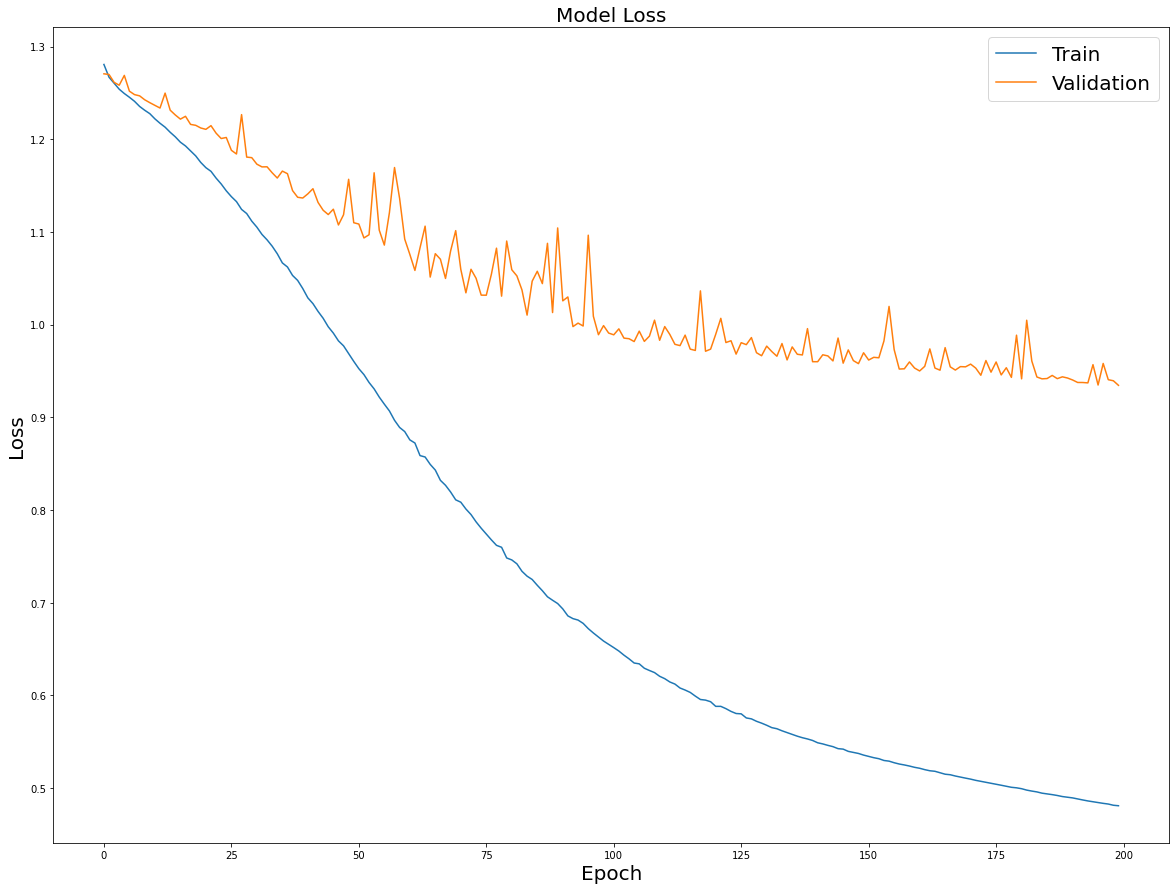

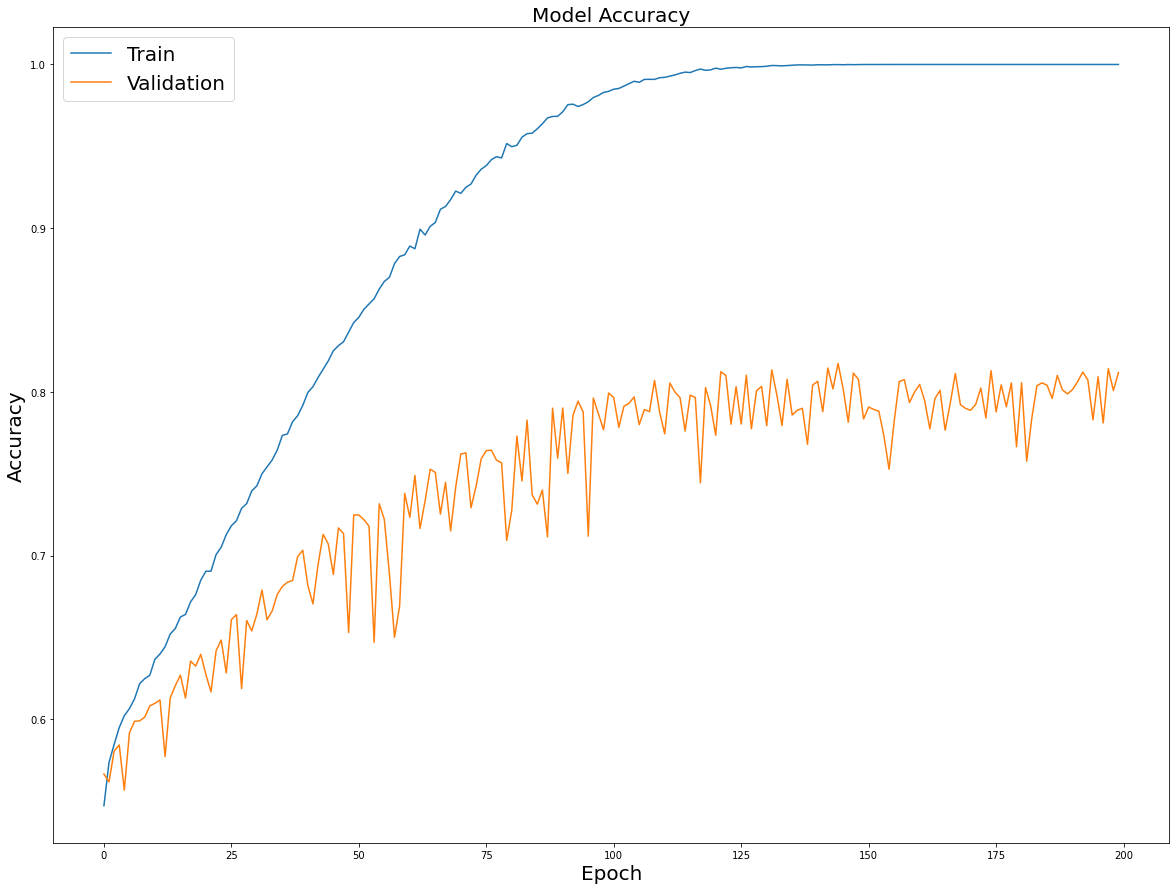

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize=(20,15))
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

In [5]:
model.load_weights("weights.best.hdf5")
model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['binary_accuracy'])

2022-08-30 12:02:15.690454: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Confusion matrix:
 [[13370  1435]
 [ 3827 10846]]


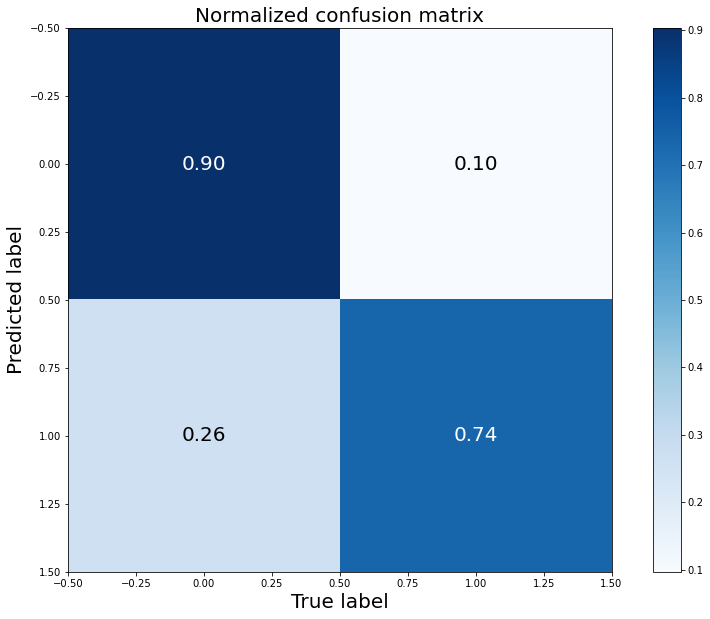

In [43]:
from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize=(15,10))

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

Configuration:<br>
[True positive&emsp;False Positive<br>
False negative&emsp;True negative]

In [29]:
from tensorflow import keras
#model.save('/Users/adriandoerr/Desktop/Bioinformatik/processingNGSdata/ipynbs/ML_model')
model = keras.models.load_model('/Users/adriandoerr/Desktop/Bioinformatik/processingNGSdata/ipynbs/ML_model')

In [28]:
X_test = np.array(X_test)
y_test = np.array(y_test)
scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

2022-09-19 16:13:22.663377: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Accuracy: 82.15%


__Random Forest__

In [38]:
import pickle
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import itertools
from sklearn.metrics import confusion_matrix

classifier = RandomForestClassifier(n_estimators = 500) # number of trees in the Forest
classifier.fit(X_train, y_train)

#pickle.dump(classifier, open('pickle_checkpoints/RF_model_Neand_Intr_vs_Depl.sav', 'wb'))

RandomForestClassifier(n_estimators=500)

Confusion matrix:
 [[14714    91]
 [ 4384 10289]]


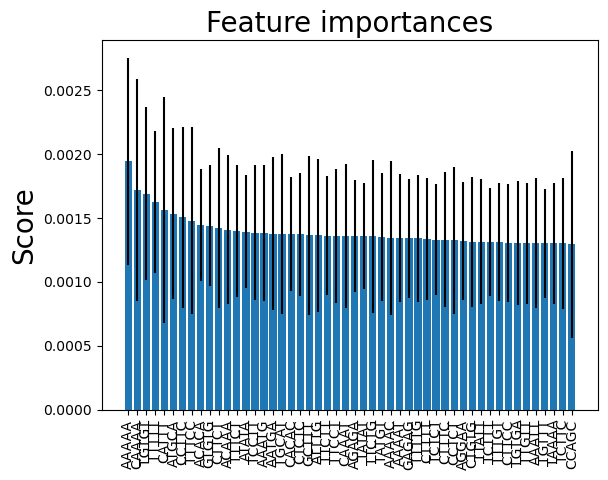

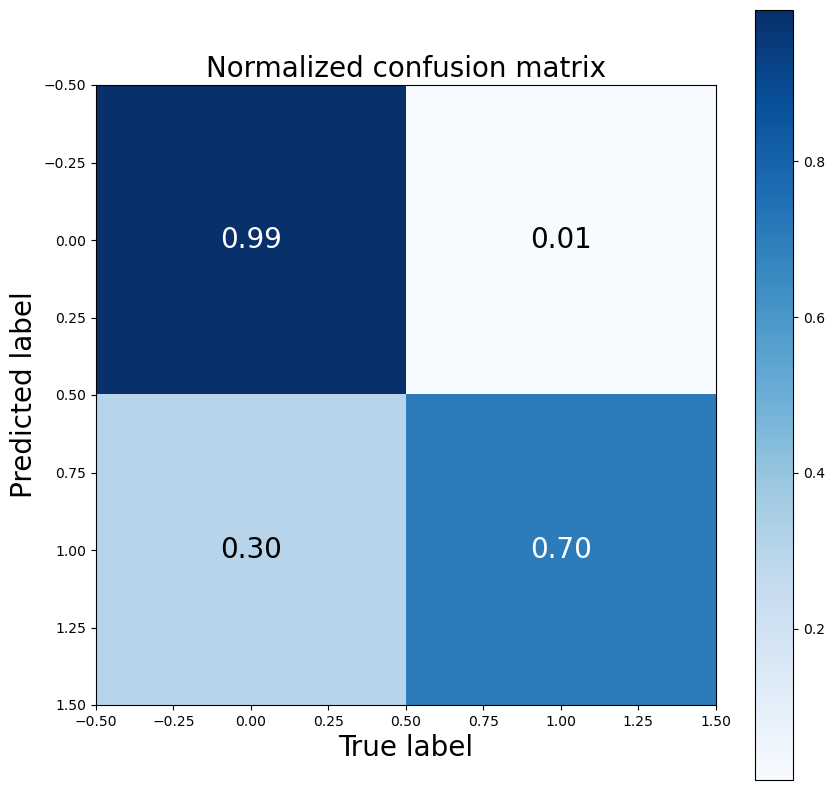

In [44]:
#with open('../pickle_checkpoints/RF_model_Neand_Intr_vs_Depl.sav', 'rb') as RFmodel:
        #classifier = pickle.load(RFmodel)

y_pred = classifier.predict(X_test)

importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]
plt.title("Feature importances", fontsize = 20)
plt.bar(range(X_train.shape[1])[0:50], importances[indices][0:50], 
        yerr = std[indices][0:50], align = "center")
plt.xticks(rotation = 90); plt.ylabel('Score', fontsize = 20)
plt.xticks(range(X_train.shape[1])[0:50], np.array(names)[indices][0:50])

plt.figure(figsize=(10,10))

cm = confusion_matrix(y_test, [np.round(i) for i in y_pred])
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 20)
plt.colorbar()
plt.xlabel('True label', fontsize = 20)
plt.ylabel('Predicted label', fontsize = 20)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [ ]:
names = cv.get_feature_names()
names = [i.upper() for i in names]
feature_import = sorted(zip(map(lambda x: str(round(x, 5)), classifier.feature_importances_), names), 
                        reverse = True)
feature_import[0:10]

[('0.00194', 'AAAAA'),
 ('0.00172', 'CAAAA'),
 ('0.00169', 'TGTGT'),
 ('0.00162', 'TTTTT'),
 ('0.00156', 'CATTT'),
 ('0.00153', 'ATGCA'),
 ('0.0015', 'CCTTC'),
 ('0.00148', 'TTTCC'),
 ('0.00144', 'GTGTG'),
 ('0.00144', 'ACACA')]

In [70]:
from sklearn.metrics import accuracy_score

y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

0.8490738856096072

In [71]:
"""
Workaround for the Generation of RefSeq annotation file:
    download from http://genome.ucsc.edu/cgi-bin/hgTables -> clade Mammal, genome Human, assembly Feb. 2009 (GRCh37/hg19), group Genes and Gene Prediction, track NCBI RefSeq, table RefSeq All (ncbiRefSeq)
retrieved all unique name2 IDs from this file since it worked with the downstream processing and removed the header
    awk -F '\t' '{ print $13}' hg19.txt | uniq | tail -n +2 > hg19_awk_c1.txt
proceeded like in DeepLearningNeanderthalIntrogression.ipynb in R
    library("biomaRt")
    path <- path.cat("/Users/adriandoerr/Desktop/Bioinformatik/processingNGSdata/ipynbs/data/")
    ensembl <- useMart("ensembl",host="https://grch37.ensembl.org")
    ensembl <- useDataset("hsapiens_gene_ensembl",mart=ensembl)
    refseq_genes <- scan(paste(path,"hg19_awk_c1.txt",sep=""), what = "character")
    output <- getBM(attributes=c('hgnc_symbol', 'chromosome_name', 'start_position', 'end_position', 'strand'), 
        filters = c('hgnc_symbol'), values = refseq_genes, mart = ensembl)
    
    output_clean <- output[as.character(output$chromosome_name)%in%c(as.character(seq(1:22)),"X","Y"),]

    output_to_write <- output_clean
    output_to_write$hgnc_symbol <- NULL
    output_to_write$strand <- NULL
    output_to_write$chromosome_name <- paste0("chr",output_to_write$chromosome_name)
    write.table(output_to_write, file=paste(path,"gene_coords.txt",sep=""),col.names=FALSE,row.names=FALSE,quote=FALSE,sep="\t")
    gene <- output_to_write
    write.table(gene[!duplicated(paste0(gene$V1,":",gene$V2,"-",gene$V3)),],
                file="gene_coords_sorted_unique.txt",col.names = FALSE,row.names = FALSE,
                quote = FALSE,sep = "\t")
                
Note: At some point after creating this Workaround, the original author answered and uploaded his refseq file to github. From here in, it was continued with his file.
"""

## Model Usage on Human Genes  <a class="anchor" id="Model-on-genes"></a>

__Creating gene dataset__

In [36]:
%%bash
echo -e "before" ; cat refGene_hg19.gtf | head -1
cut -f9 refGene_hg19.gtf | cut -d ';' -f1 | cut -d ' ' -f2 | uniq | tr -d '\"' > refseq_gene_list_hg19.txt
echo -e "\nafter" ; cat refseq_gene_list_hg19.txt | head -1
cat refseq_gene_list_hg19.txt | wc -l

before
chr1	stdin	transcript	11874	14409	.	+	.	gene_id "DDX11L1"; transcript_id "NR_046018";  gene_name "DDX11L1";

after
DDX11L1
   49762


In [ ]:
%%R

library("biomaRt")
path <- ("/Users/adriandoerr/Desktop/Bioinformatik/processingNGSdata/ipynbs/data/")
ensembl <- useMart("ensembl",host="https://grch37.ensembl.org")
ensembl <- useDataset("hsapiens_gene_ensembl",mart=ensembl)
refseq_genes <- scan(paste(path,"refseq_gene_list_hg19.txt",sep=""), what = "character")
output <- getBM(attributes=c('hgnc_symbol', 'chromosome_name', 'start_position', 'end_position', 'strand'), 
      filters = c('hgnc_symbol'), values = refseq_genes, mart = ensembl)
head(output)

output_clean <- output[as.character(output$chromosome_name)%in%c(as.character(seq(1:22)),"X","Y"),]

output_to_write <- output_clean
output_to_write$hgnc_symbol <- NULL
output_to_write$strand <- NULL
output_to_write$chromosome_name <- paste0("chr",output_to_write$chromosome_name)
write.table(output_to_write, file=paste(path,"gene_coords.txt",sep=""),col.names=FALSE,row.names=FALSE,quote=FALSE,sep="\t")
gene <- output_to_write

In [32]:
import pandas as pd
Path = '/Users/adriandoerr/Desktop/Bioinformatik/processingNGSdata/ipynbs/data/'
gene_coords = pd.read_csv(Path + 'gene_coords.txt', 
                          header=None, sep="\t")
print(gene_coords.head(3))

       0         1         2
0  chr10  52559169  52645435
1   chr4    419224    467918
2  chr17  67074843  67138029


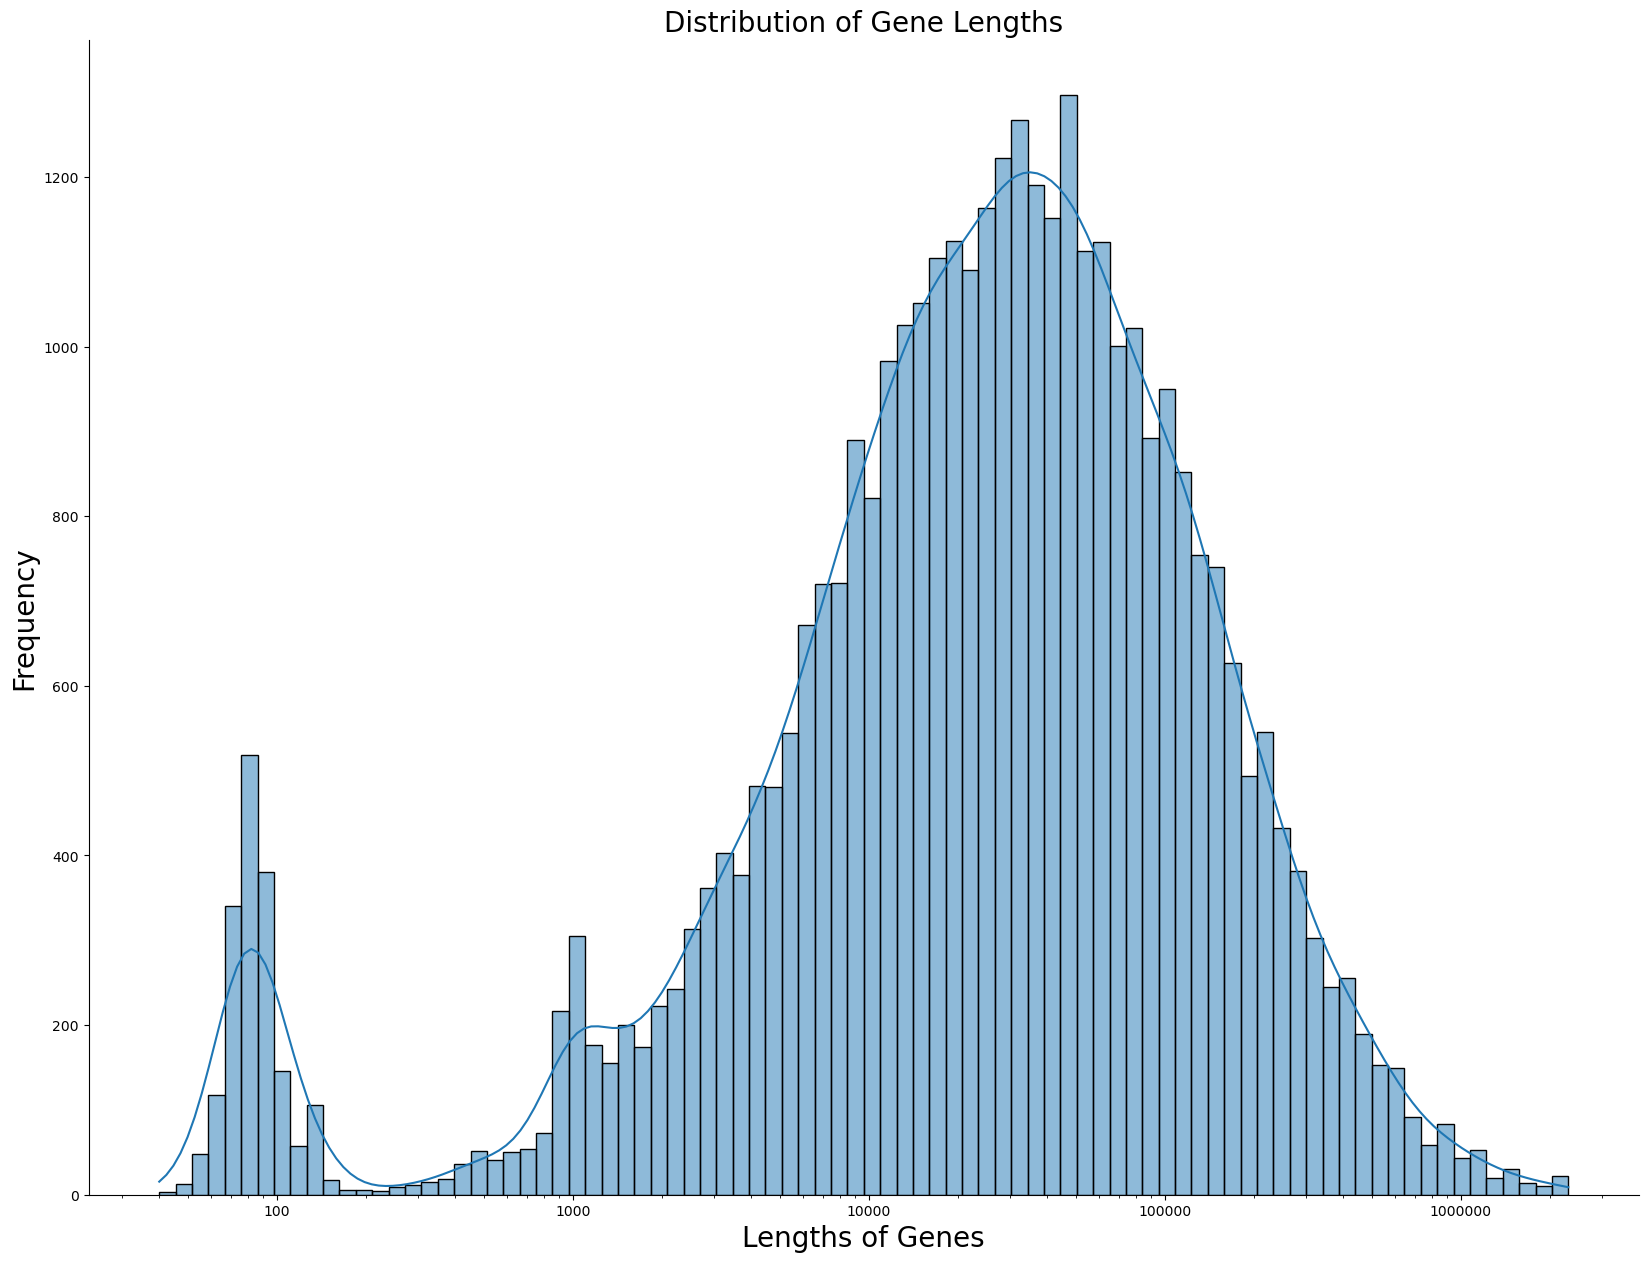

In [112]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(20,15))
sns.despine(f)
gene_lengths = gene_coords.iloc[:, 2]-gene_coords.iloc[:, 1]
sns.histplot(gene_lengths, kde=True, log_scale=True)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.ticklabel_format(style='plain')
plt.title("Distribution of Gene Lengths", fontsize = 20)
plt.xlabel("Lengths of Genes", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.show()

__Assigning sequences to genes__

In [156]:
import os
import subprocess
os.chdir('/Users/adriandoerr/Desktop/Bioinformatik/processingNGSdata/ipynbs/data')
with open('hg19_gene_regions.fa', 'a') as fp:
    for i in range(gene_coords.shape[0]):
        coord = str(str(gene_coords.iloc[i, 0]) + ':' 
                    + str(gene_coords.iloc[i, 1]) + '-' + str(gene_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.gz', str(coord)], stdout = fp)

In [27]:
from Bio import SeqIO

gene_file = 'hg19_gene_regions.fa'
a = 0
i = 0
with open(Path + 'hg19_gene_clean.fa', 'a') as gene_out:
    for gene in SeqIO.parse(gene_file, 'fasta'):
        upper_gene = gene.seq.upper()
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' entries')
        if 'N' not in str(upper_gene):
            gene.seq = upper_gene
            SeqIO.write(gene, gene_out, 'fasta')
            i = i + 1
        else:
            continue
print('We have processed ' + str(a) + ' entries and written ' + str(i) + ' entries to a fastafile')

Finished 10000 entries
Finished 20000 entries
Finished 30000 entries
We have processed 36922 entries and written 36831 entries to a fastafile


In [30]:
from Bio import SeqIO
gene_seqs = []
gene_ids = []
a = 0
for gene in SeqIO.parse('hg19_intr_clean.fa', 'fasta'):
    cut = 8800
    if len(str(gene.seq)) < cut:
        continue
    s_gene = str(gene.seq)[0:cut]
    if s_gene.count('A')>0 and s_gene.count('C')>0 and s_gene.count('G')>0 \
    and s_gene.count('T')>0:
        gene_seqs.append(s_gene)
        gene_ids.append(str(gene.id))
    a = a + 1
    if a%10000 == 0:
        print('Finished ' + str(a) + ' genes')

def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 5
gene_texts = [' '.join(getKmers(i, kmer)) for i in gene_seqs]

Finished 10000 genes
Finished 20000 genes
Finished 30000 genes
Finished 40000 genes
Finished 50000 genes
Finished 60000 genes
Finished 70000 genes


In [27]:
#since the assigning of gene ids did not work as intended, I programmed my own way to do this
import os
import pickle
os.chdir('/Users/adriandoerr/Desktop/Bioinformatik/processingNGSdata/ipynbs')

with open('gene_ids.txt', 'w') as f, open('data/Akey_intr_coords.bed') as id:
    for item,item2 in zip(gene_ids, id):
        line = item2.split('\t')
        f.write("{}\t{}".format(item,line[4]))

__Predicting Introgression genes__

In [9]:
import pickle
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

classifier = pickle.load(open('pickle_checkpoints/RF_model_Neand_Intr_vs_Depl.sav', 'rb'))
cv = CountVectorizer(); X_gene = cv.fit_transform(gene_texts)
gene_predictions = classifier.predict(X_gene.toarray())
gene_predictions_prob = classifier.predict_proba(X_gene.toarray())
gene_predictions_prob_0 = [i[0] for i in gene_predictions_prob]
gene_predictions_prob_1 = [i[1] for i in gene_predictions_prob]

In [20]:
gene_ids = []; gene_symbol = []
with open('data/gene_ids.txt','r') as fin:
    for line in fin:
        line = line.split('\t')
        gene_ids.append(line[0])
        gene_symbol.append(line[1].rstrip())

In [16]:
gene_pred_df = pd.DataFrame({'Gene': gene_ids, 'Gene_Symbol': gene_symbol, 
                            'Predict': gene_predictions, 
                            'Prob_0': gene_predictions_prob_0, 
                            'Prob_1': gene_predictions_prob_1})
gene_pred_df = gene_pred_df.sort_values(['Prob_1'], ascending = False)

In [18]:
gene_pred_df.head(20)

,Gene,Gene_Symbol,Predict,Prob_0,Prob_1
12670,chr12:130862317-130897150,NA12249,1.0,0.168,0.832
12671,chr12:130862317-130913323,HG01761,1.0,0.168,0.832
12672,chr12:130862317-130915613,HG00371,1.0,0.168,0.832
7155,chr17:11802-76510,HG00142,1.0,0.224,0.776
7154,chr17:11802-56951,NA11994,1.0,0.224,0.776
7153,chr17:11802-52445,HG01710,1.0,0.224,0.776
12667,chr12:130862014-130927752,HG01705,1.0,0.240,0.760
12663,chr12:130862014-130913323,NA20535,1.0,0.240,0.760
12665,chr12:130862014-130917585,HG01536,1.0,0.240,0.760
12662,chr12:130862014-130904094,HG00242,1.0,0.240,0.760


In [34]:
gene_pred_df.to_csv('Neanderthal_Genes.txt', header=True, index = False, sep = "\t")

## Finding Intersections <a class="anchor" id="Finding-Intersections"></a>

__Intersections between genes and introgressions/depletions__

In [23]:
%%bash
Path=/Users/adriandoerr/Desktop/Bioinformatik/processingNGSdata/ipynbs/data
echo "gene - introgression intersections:"
bedtools intersect -a $Path/Akey_intr_coords.bed -b $Path/gene_coords.txt | wc -l
echo "gene - depletion intersections:"
bedtools intersect -a $Path/Akey_depl_coords.bed -b $Path/gene_coords.txt | wc -l

gene - introgression intersections:
  155524
gene - depletion intersections:
  164198


In [ ]:
import subprocess
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

intr_coords = pd.read_csv('data/Akey_intr_coords.bed', header = None, sep = "\t")
chr_sizes = pd.read_csv("data/hg19.fa.fai", header = None, sep = "\t")
chr_sizes = chr_sizes.drop([2, 3, 4], axis = 1)

perm_n = []
for k in range(1):
    chr_list = []; start_list = []; end_list = []
    intr_lengths = list(intr_coords.iloc[:, 2] - intr_coords.iloc[:, 1])
    a = 0
    for i in range(intr_coords.shape[0]):
        chr_df = intr_coords[intr_coords[0].isin([intr_coords.iloc[i,0]])]
        overlap = True
        while overlap == True:
            reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == intr_coords.iloc[i,0]].iloc[:,1]))
            reg_end = reg_start + intr_lengths[i]
            for j in range(chr_df.shape[0]):
                b1 = chr_df.iloc[j,1]; b2 = chr_df.iloc[j,2]
                if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2) or (b1 > reg_start and b1 < reg_end) or (b2 > reg_start and b2 < reg_end):
                    overlap = True
                    break
                else:
                    overlap = False
        chr_list.append(intr_coords.iloc[i,0])
        start_list.append(reg_start); end_list.append(reg_end)
        a = a + 1
        if a%20000 == 0:
            print('Finished ' + str(a) + ' Neanderthal haplotypes')
    depl_coords = pd.DataFrame({'0': chr_list, '1': start_list, '2': end_list})
    depl_coords.to_csv("depl_temp.txt", index = False, header = False, sep = "\t")


    with open('n_intersects.txt', 'w') as fp:
        subprocess.run(['bedtools', 'intersect', '-a', 'depl_temp.txt', '-b', 'data/gene_coords.txt'], stdout = fp)
    akey_n = pd.read_csv('n_intersects.txt', header = None, sep = "\t")
    print(k, akey_n.shape[0])
    print('**********************************************************')
    perm_n.append(akey_n.shape[0])

/Users/adriandoerr/mambaforge/envs/ngspy/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

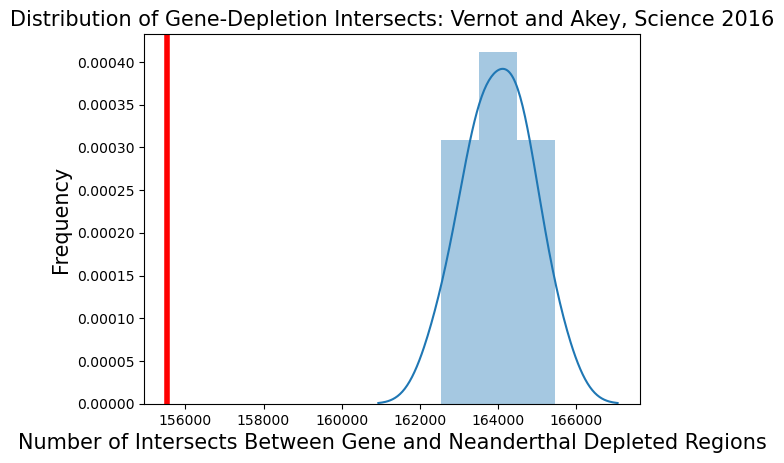

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.axvline(x = 155524, linewidth = 4, color = 'r') 
perm_n = [163650,164688,163400,163779,162536,164297,165450,163270,164608,164442]
sns.distplot(perm_n)
plt.title("Distribution of Gene-Depletion Intersects: Vernot and Akey, Science 2016", 
          fontsize = 15)
plt.xlabel("Number of Intersects Between Gene and Neanderthal Depleted Regions", 
           fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)